In [30]:
import csv
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import sys
import pandas as pd
import ast
import importlib

sys.path.append('../representation-engineering')
sys.path.append('../representation-engineering/examples/primary_emotions')
sys.path.append('../')
if 'playscript_utils' in sys.modules:
    importlib.reload(sys.modules['playscript_utils'])
else:
    import playscript_utils
from playscript_utils import model_name_dict, emotions, filter_csv_by_columns
from repe import repe_pipeline_registry
repe_pipeline_registry()
importlib.reload(sys.modules['utils'])

from utils import primary_emotions_concept_dataset

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...


In [17]:
def get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag, stimulis_format, dialogue_concatenate):
    generated_playscripts = pd.read_csv(generated_playscripts_path)
    dialogue_data = {emotion: {"test": {"data": []}} for emotion in emotions}
    dialogue_data_origins = {}
    if stimulis_format == "rep e":
        template_str = '{user_tag} Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer: {assistant_tag} '
    elif stimulis_format == "conversation":
        template_str = '{user_tag} Consider the {emotion} of the following conversation:\n{scenario}\nAnswer: {assistant_tag} '
    elif stimulis_format == "simple":
        template_str = '{user_tag} {scenario}\n{assistant_tag} '
    else:
        raise ValueError(f"Invalid stimulis format: {stimulis_format}")

    for premise_id, row in generated_playscripts.iterrows():
        dialogues = ast.literal_eval(row["dialogues"])
        running_dialogue = ""
        for dialogue_id, dialogue in enumerate(dialogues):
            if dialogue_concatenate:
                character_prefix = "Alice" if dialogue_id % 2 == 0 else "Bob"
                running_dialogue += "\n" if dialogue_id != 0 else ""
                running_dialogue += f"{character_prefix}: {dialogue}"
                formatted_dialogue = running_dialogue
            else:
                formatted_dialogue = dialogue
            for emotion in emotions:
                formatted_dialogue = template_str.format(user_tag=user_tag, emotion=emotion, scenario=formatted_dialogue, assistant_tag=assistant_tag)
                if formatted_dialogue in dialogue_data_origins:
                    dialogue_data_origins[formatted_dialogue].append({"premise id": premise_id, "dialogue id": dialogue_id, "emotion": emotion})
                else:
                    dialogue_data[emotion]['test']['data'].append(formatted_dialogue)
                    dialogue_data_origins[formatted_dialogue] = [{"premise id": premise_id, "dialogue id": dialogue_id, "emotion": emotion}]
    return dialogue_data, dialogue_data_origins

In [18]:
def get_emotion_rep_readers(emotions, rep_reading_pipeline, data, rep_token, hidden_layers, n_difference, direction_method):
    emotion_rep_readers = {}

    for emotion in tqdm(emotions):
        print("Getting rep reader for emotion", emotion)
        train_data = data[emotion]['train']
        rep_reader = rep_reading_pipeline.get_directions(
            train_data['data'], 
            rep_token=rep_token, 
            hidden_layers=hidden_layers, 
            n_difference=n_difference, 
            train_labels=train_data['labels'], 
            direction_method=direction_method,
        )
        emotion_rep_readers[emotion] = rep_reader
    return emotion_rep_readers

In [19]:
def run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, data, rep_token, hidden_layers):
    emotion_H_tests = {}
    for emotion in tqdm(emotions):
        print("Running H tests for emotion", emotion)
        test_data = data[emotion]['test']
        rep_reader = emotion_rep_readers[emotion]
        H_tests = rep_reading_pipeline(
            test_data['data'],
            rep_token=rep_token, 
            hidden_layers=hidden_layers, 
            rep_reader=rep_reader,
            batch_size=32)
        emotion_H_tests[emotion] = H_tests
    return emotion_H_tests            

In [20]:
def evaluate_classification_accuracy(emotions, emotion_rep_readers, emotion_H_tests, data, hidden_layers, probing_model_name, probing_method):
    results = {method: {layer: {} for layer in hidden_layers} for method in ["pairwise relative", "absolute zero boundary", "absolute average boundary"]}
    
    for layer in hidden_layers:
        for emotion in emotions:
            test_data = data[emotion]['test']
            sign = emotion_rep_readers[emotion].direction_signs[layer].item()
            
            # Pairwise relative
            H_test = [H[layer] for H in emotion_H_tests[emotion]] 
            H_test_pairs = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
            eval_func = min if sign == -1 else max
            cors = np.mean([eval_func(H) == H[0] for H in H_test_pairs])
            results["pairwise relative"][layer][emotion] = cors

            # Absolute zero boundary
            H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
            cors = np.mean([(H_test[i] > 0) == (test_data['labels'][0][i] == 1) for i in range(len(H_test))])
            results["absolute zero boundary"][layer][emotion] = cors

            # Absolute average boundary
            H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
            avg_H_test = np.mean(H_test)
            cors = np.mean([(H_test[i] > avg_H_test) == (test_data['labels'][0][i] == 1) for i in range(len(H_test))])
            results["absolute average boundary"][layer][emotion] = cors

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for idx, method in enumerate(["pairwise relative", "absolute zero boundary", "absolute average boundary"]):
        for emotion in emotions:
            x = list(results[method].keys())
            y = [results[method][layer][emotion] for layer in results[method]]
            axs[idx].plot(x, y, label=emotion)
        
        axs[idx].set_title(f"Emotions Acc: {method}")
        axs[idx].set_xlabel("Layer")
        axs[idx].set_ylabel("Acc")
        axs[idx].legend(loc="best")
        axs[idx].grid(True)
    fig.suptitle(f"Comparison of emotion classification evaluation methods on rep e test data with probing model {probing_model_name} and probing method {probing_method}", wrap=True)

    plt.tight_layout()
    plt.show()
    output_path = f"../results/emotion_classification_accuracy/probing_model-{probing_model_name}-probing_method-{probing_method}"
    fig.savefig(output_path)

In [21]:
def sweep_emotion_classification_accuracy(baseline_data_path, emotions, probing_model_names, probing_methods):
    for probing_model_name in probing_model_names:
        if probing_model_name == "llama2_13b_chat":
            user_tag =  "[INST]"
            assistant_tag =  "[/INST]"
        else:
            raise NotImplementedError("This functionality is not implemented yet.")
        baseline_data = primary_emotions_concept_dataset(baseline_data_path, user_tag=user_tag, assistant_tag=assistant_tag)

        probing_model_HF = model_name_dict[probing_model_name]
        probing_model = AutoModelForCausalLM.from_pretrained(probing_model_HF, torch_dtype=torch.float16, device_map="auto", token=True).eval()
        # use_fast_tokenizer = "LlamaForCausalLM" not in probing_model.config.architectures
        # tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
        tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, padding_side="left", legacy=False, token=True)
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1

        rep_reading_pipeline = pipeline("rep-reading", model=probing_model, tokenizer=tokenizer)
        rep_token = -1
        hidden_layers = list(range(-1, -probing_model.config.num_hidden_layers, -1))
        
        for probing_method in probing_methods:
            if probing_method == "pca":
                n_difference = 1
            elif probing_method == "logistic_regression":
                n_difference = 0
            baseline_emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, baseline_data, rep_token, hidden_layers, n_difference, probing_method)
            baseline_emotion_H_tests = run_emotion_H_tests(emotions, baseline_emotion_rep_readers, rep_reading_pipeline, baseline_data, rep_token, hidden_layers)
            evaluate_classification_accuracy(emotions, baseline_emotion_rep_readers, baseline_emotion_H_tests, baseline_data, hidden_layers, probing_model_name, probing_method)

In [22]:
def get_emotion_scores(emotions, emotion_rep_readers, emotion_H_tests, data, layer):
    emotion_scores = {emotion: [] for emotion in emotions}
    for emotion in emotions:
        test_data = data[emotion]['test']
        sign = emotion_rep_readers[emotion].direction_signs[layer].item()
        H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
        # avg_H_test = np.mean(H_test)
        for i in range(len(test_data['data'])):
            emotion_scores[emotion].append((test_data['data'][i], H_test[i]))
    return emotion_scores

In [23]:
def write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, dialogue_data_origins, emotion_scores, probing_model_name, probing_method, stimulis_format, dialogue_concatenate):
    df = pd.read_csv(generated_playscripts_path)

    # Initialize the new columns
    df['probing_model'] = [probing_model_name for _ in range(len(df))]
    df['probing_method'] = [probing_method for _ in range(len(df))]
    df['stimulis_format'] = [stimulis_format for _ in range(len(df))]
    df['dialogue_concatenate'] = [dialogue_concatenate for _ in range(len(df))]
    df['emotion_scores'] = [{} for _ in range(len(df))]
    
    # Populate the df with emotion_scores = {happiness: [0, 0, 0, 0, 0, 0], ...} for each playscript
    for i in range(len(df)):
        dialogues_length = df.at[i, 'dialogues_length']
        for emotion in emotions:
            df.at[i, 'emotion_scores'][emotion] = [0] * dialogues_length

    # Write Alice and Bob's emotion scores
    for emotion in emotions:
        for formatted_dialogue, emotion_score in emotion_scores[emotion]:
            origin_info = dialogue_data_origins[formatted_dialogue]
            for match in origin_info:
                premise_id = match["premise id"]
                dialogue_id = match["dialogue id"]
                df.at[premise_id, 'emotion_scores'][emotion][dialogue_id] = emotion_score
    df.to_csv(emotion_metrics_path, mode='a', index=False, header=True)


In [24]:
def sweep_emotion_scoring(baseline_data_path, generated_playscripts_path, emotion_metrics_path, probing_model_names, probing_methods, stimulis_formats, dialogue_concatenates):
    for probing_model_name in probing_model_names:
        if probing_model_name == "llama2_13b_chat":
            user_tag =  "[INST]"
            assistant_tag =  "[/INST]"
        else:
            raise NotImplementedError("This functionality is not implemented yet.")
        baseline_data = primary_emotions_concept_dataset(baseline_data_path, user_tag=user_tag, assistant_tag=assistant_tag)

        probing_model_HF = model_name_dict[probing_model_name]
        probing_model = AutoModelForCausalLM.from_pretrained(probing_model_HF, torch_dtype=torch.float16, device_map="auto", token=True).eval()
        # use_fast_tokenizer = "LlamaForCausalLM" not in probing_model.config.architectures
        # tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
        tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, padding_side="left", legacy=False, token=True)
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1

        rep_reading_pipeline = pipeline("rep-reading", model=probing_model, tokenizer=tokenizer)
        rep_token = -1
        hidden_layers = list(range(-1, -probing_model.config.num_hidden_layers, -1))
        
        for probing_method in probing_methods:
            if probing_method == "pca":
                n_difference = 1
            elif probing_method == "logistic_regression":
                n_difference = 0
            baseline_emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, baseline_data, rep_token, hidden_layers, n_difference, probing_method)
            for stimulis_format in stimulis_formats:
                for dialogue_concatenate in dialogue_concatenates:
                    print(f"probing_model: {probing_model_name}, probing_method: {probing_method}, stimulis_format: {stimulis_format}, dialogue_concatenate: {dialogue_concatenate}")
                    dialogue_data, dialogue_data_origins = get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag, stimulis_format, dialogue_concatenate)
                    dialogue_emotion_H_tests = run_emotion_H_tests(emotions, baseline_emotion_rep_readers, rep_reading_pipeline, dialogue_data, rep_token, hidden_layers)
                    dialogue_emotion_scores = get_emotion_scores(emotions, baseline_emotion_rep_readers, dialogue_emotion_H_tests, dialogue_data, layer=-1)
                    write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, dialogue_data_origins, dialogue_emotion_scores, probing_model_name, probing_method, stimulis_format, dialogue_concatenate)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Getting rep reader for emotion happiness


 17%|█▋        | 1/6 [00:03<00:17,  3.49s/it]

Getting rep reader for emotion sadness


 33%|███▎      | 2/6 [00:06<00:13,  3.34s/it]

Getting rep reader for emotion anger


 50%|█████     | 3/6 [00:09<00:09,  3.28s/it]

Getting rep reader for emotion fear


 67%|██████▋   | 4/6 [00:13<00:06,  3.25s/it]

Getting rep reader for emotion disgust


 83%|████████▎ | 5/6 [00:16<00:03,  3.24s/it]

Getting rep reader for emotion surprise


  0%|          | 0/6 [00:00<?, ?it/s]

Running H tests for emotion happiness


 17%|█▋        | 1/6 [00:01<00:07,  1.40s/it]

Running H tests for emotion sadness


 33%|███▎      | 2/6 [00:02<00:05,  1.39s/it]

Running H tests for emotion anger


 50%|█████     | 3/6 [00:04<00:04,  1.38s/it]

Running H tests for emotion fear


 67%|██████▋   | 4/6 [00:05<00:02,  1.38s/it]

Running H tests for emotion disgust


 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]

Running H tests for emotion surprise


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


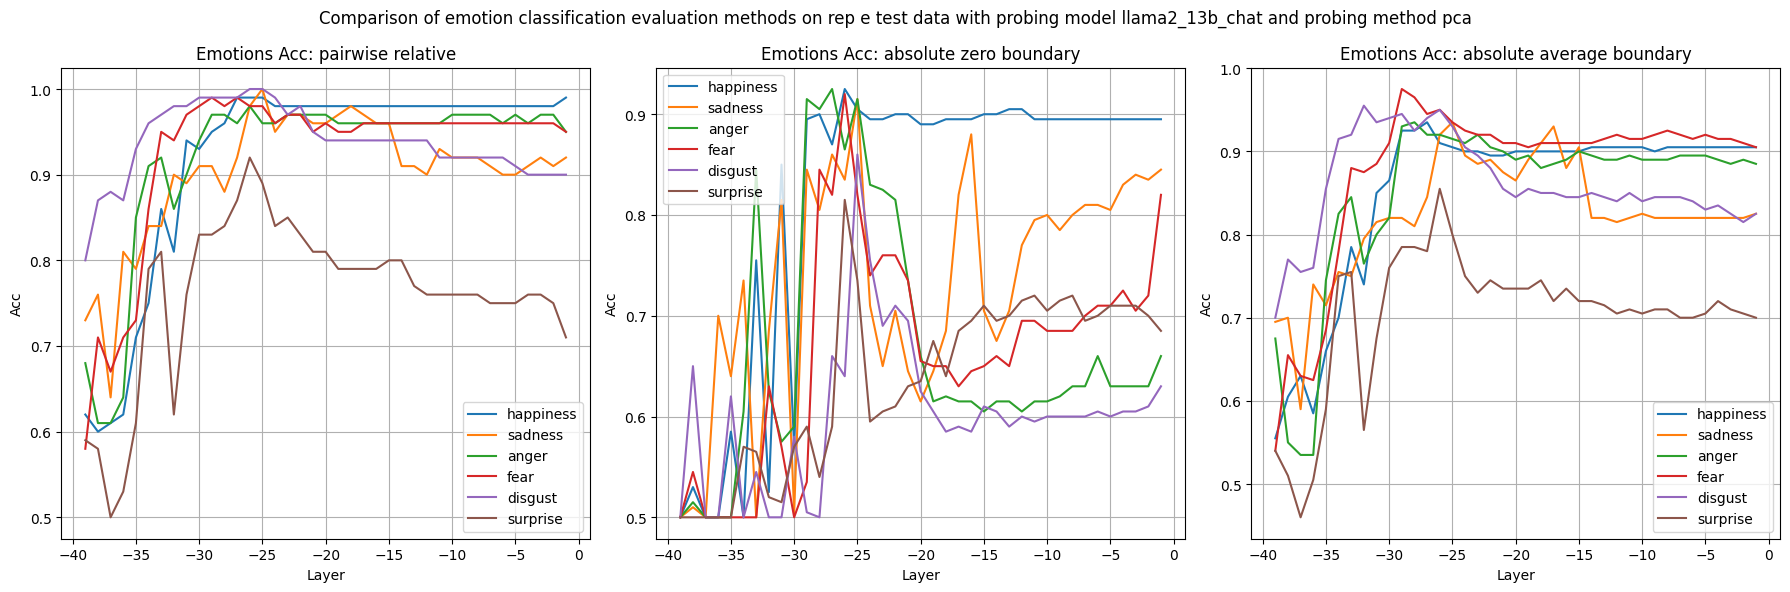

In [27]:
baseline_data_path = "../representation-engineering/data/emotions"
generated_playscripts_path = "../data/permanent/generated_playscripts.csv"
emotion_metrics_path = "../data/temp/emotion_metrics.csv"
probing_model_names = ["llama2_13b_chat"]
probing_methods = ["pca"]
stimulis_formats = ["simple", "rep e", "conversation"]
dialogue_concatenates = [True, False]
# sweep_emotion_scoring(baseline_data_path, generated_playscripts_path, emotion_metrics_path, probing_model_names, probing_methods, stimulis_formats, dialogue_concatenates)
sweep_emotion_classification_accuracy(baseline_data_path, emotions, probing_model_names, probing_methods)

# Runtimes:
# Getting rep reader: 0:30
# 5:39 (simple, True), 1:50 (simple, False), 6:47 (rep e, True), 3:07 (rep e, False), 6:30 (conversation, True), 2:54 (conversation, False) 

In [31]:
baseline_data = primary_emotions_concept_dataset(baseline_data_path, user_tag="[INST]", assistant_tag="[/INST]")
# print(len(baseline_data["happiness"]["train"]["data"]))
# print(len(baseline_data["happiness"]["train"]["labels"]))
# print(len(baseline_data["happiness"]["test"]["data"]))
# print(len(baseline_data["happiness"]["test"]["labels"][0]))

# print(baseline_data["happiness"]["train"]["data"])
# print(baseline_data["happiness"]["train"]["labels"])
# print(baseline_data["happiness"]["test"]["data"])
# print(baseline_data["happiness"]["test"]["labels"])

['You try on an outfit, and it fits perfectly.', 'A kite soars majestically against a backdrop of blue sky.', 'Your favorite author replies to your letter or message.', 'Your morning starts with your favorite breakfast.', 'A group of kids include you in their playful game.']
['You try on an outfit, and it fits perfectly.', 'A kite soars majestically against a backdrop of blue sky.', 'Your favorite author replies to your letter or message.', 'Your morning starts with your favorite breakfast.', 'A group of kids include you in their playful game.']
['A poem describes the feeling of being forgotten.'
 'An artwork you see depicts a longing for home.'
 'You learn about a community struggling post a natural disaster.'
 'A show you watch portrays the challenges of growing up.'
 'You find a forgotten gift, never given, gathering dust.']
[['You try on an outfit, and it fits perfectly.', "You hear sirens and realize they're coming toward your location."], ['A kite soars majestically against a bac